In [1]:
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

In [2]:
class StocksAnalyzer:
    def __init__(self):
        self.companies = {}
        self.stock_list = []
        self.start = None
        self.end = None
    
    def initialize(self, stock_list, end=None, start=None):
         """
        Initialize the class with a list of stock tickers and optional start/end date for data retrieval.

        Args:
            stock_list (list): List of stock tickers to analyze.
            end (datetime): End date for data retrieval (default is today).
            start (datetime): Start date for data retrieval (default is one year ago from end date).
        """
        if end is None:
            end = datetime.now()
        if start is None:
            start = datetime(end.year - 1, end.month, end.day)
            
        self.stock_list = stock_list
        
        for stock in stock_list:
            self.companies[stock] = yf.download(stock, start, end)
    
    def visualize(self, col):
        """
        Visualize a specified column (e.g., 'Adj Close' or 'Volume') for all the stocks in the portfolio.

        Args:
            col (str): Name of the column to visualize.
        """
        plt.figure(figsize=(15, 10))
        plt.subplots_adjust(top=1.25, bottom=1.2)

        num_plots = len(self.companies)
        num_rows = num_plots // 2
        num_cols = num_plots % 2 + 1 if num_plots % 2 != 0 else 2

        for i, (company, ticker) in enumerate(zip(self.companies.values(), self.stock_list), 1):
            plt.subplot(num_rows, num_cols, i)
            company[col].plot()
            plt.xlabel(None)
            plt.ylabel(col)
            plt.title(col + f" of {ticker}")
        
        plt.tight_layout()
        plt.show()

    def moving_average(self, ma_day):
        """
        Calculate and visualize moving averages for a list of specified days.

        Args:
            ma_day (list): List of integers representing the number of days for the moving averages.
        """
        for ma in ma_day:
            for company in self.companies.values():
                column_name = f"MA for {ma} days"
                company[column_name] = company['Adj Close'].rolling(ma).mean()
        
        num_plots = len(self.companies)
        num_rows = num_plots // 2
        num_cols = num_plots % 2 + 1 if num_plots % 2 != 0 else 2
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        for i, (company, name) in enumerate(zip(self.companies.values(), self.stock_list)):
            row = i // 2
            col = i % 2
            to_plot = ['Adj Close'] + [f'MA for {ma} days' for ma in ma_day]
            company[to_plot].plot(ax=axes[row, col])
            axes[row, col].set_title(name)

        plt.tight_layout()
        plt.show()
    
    def daily_return(self, histo=False):
        """
        Calculate and visualize daily returns for all stocks in the portfolio.

        Args:
            histo (bool): Whether to plot histograms of daily returns (default is False, which plots line charts).
        """
        
        for company in self.companies.values():
            company['Daily Return'] = company['Adj Close'].pct_change()
    
        
        num_plots = len(self.companies.values())
        num_rows = num_plots // 2
        num_cols = num_plots % 2 + 1 if num_plots % 2 != 0 else 2
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols)

        fig.set_figheight(10)
        fig.set_figwidth(15)
        
        for i, (company, name) in enumerate(zip(self.companies.values(), self.stock_list)):
            row = i // 2
            col = i % 2
            if not histo:
                company['Daily Return'].plot(ax=axes[row, col], legend=True, linestyle='--', marker='o')
            else: 
                plt.subplot(2, 2, i+1)
                company['Daily Return'].hist(bins=50)
                plt.xlabel('Daily Return')
                plt.ylabel('Counts')
            axes[row, col].set_title(name)
        
        plt.tight_layout()
        plt.show()
    
    def closing(self):
        """
        Retrieve the closing prices for all stocks in the portfolio.

        Returns:
            pandas.DataFrame: DataFrame containing the closing prices.
        """
        return yf.download(self.stock_list, start=self.start, end=self.end)['Adj Close']

    def correlation(self, corr=True, reg=True, kde_scat=False):
        """
        Calculate and visualize correlations between stock returns and closing prices.

        Args:
            corr (bool): Whether to plot correlation matrices (default is True).
            reg (bool): Whether to plot regression plots (default is True).
            kde_scat (bool): Whether to plot scatter plots with KDEs (default is False).
        """
        closing_df = self.closing()
        rets = closing_df.pct_change()
        
        if corr:
            plt.figure(figsize=(12, 10))

            plt.subplot(2, 2, 1)
            sns.heatmap(rets.corr(), annot=True, cmap='summer')
            plt.title('Correlation of stock return')

            plt.subplot(2, 2, 2)
            sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
            plt.title('Correlation of stock closing price')

        if reg:
            pl = sns.pairplot(rets, kind='reg')
            pl.axes[0, 0].set_title('Stock returns')
        
        if kde_scat:
            return_fig = sns.PairGrid(rets.dropna())
            return_fig.map_upper(plt.scatter, color='purple')
            return_fig.map_lower(sns.kdeplot, cmap='cool_d')
            return_fig.map_diag(plt.hist, bins=30)
            
    def std_mean(self):
        """
        Calculate and visualize the mean return vs. standard deviation of returns for all stocks in the portfolio.
        """
        rets = self.closing().dropna().pct_change()
        area = np.pi * 20

        plt.figure(figsize=(10, 8))
        plt.scatter(rets.mean(), rets.std(), s=area)
        plt.xlabel('Mean return')
        plt.ylabel('Standard deviation')

        for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
            plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                         arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
    
    def analyze(self, stocks,start=None, end=None,ma=[10,20,30], reg=True,corr=True,kde_scat=False):
        if start is not None:
            self.start = start
        if end is not None:
            self.end = end
        
        self.initialize(stocks, self.end, self.start)
        self.visualize("Adj Close")
        self.visualize("Volume")
        self.moving_average(ma)
        self.daily_return()
        self.daily_return(histo=True)
        close_comp = self.closing()
        self.correlation(kde_scat=kde_scat)
        self.std_mean()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


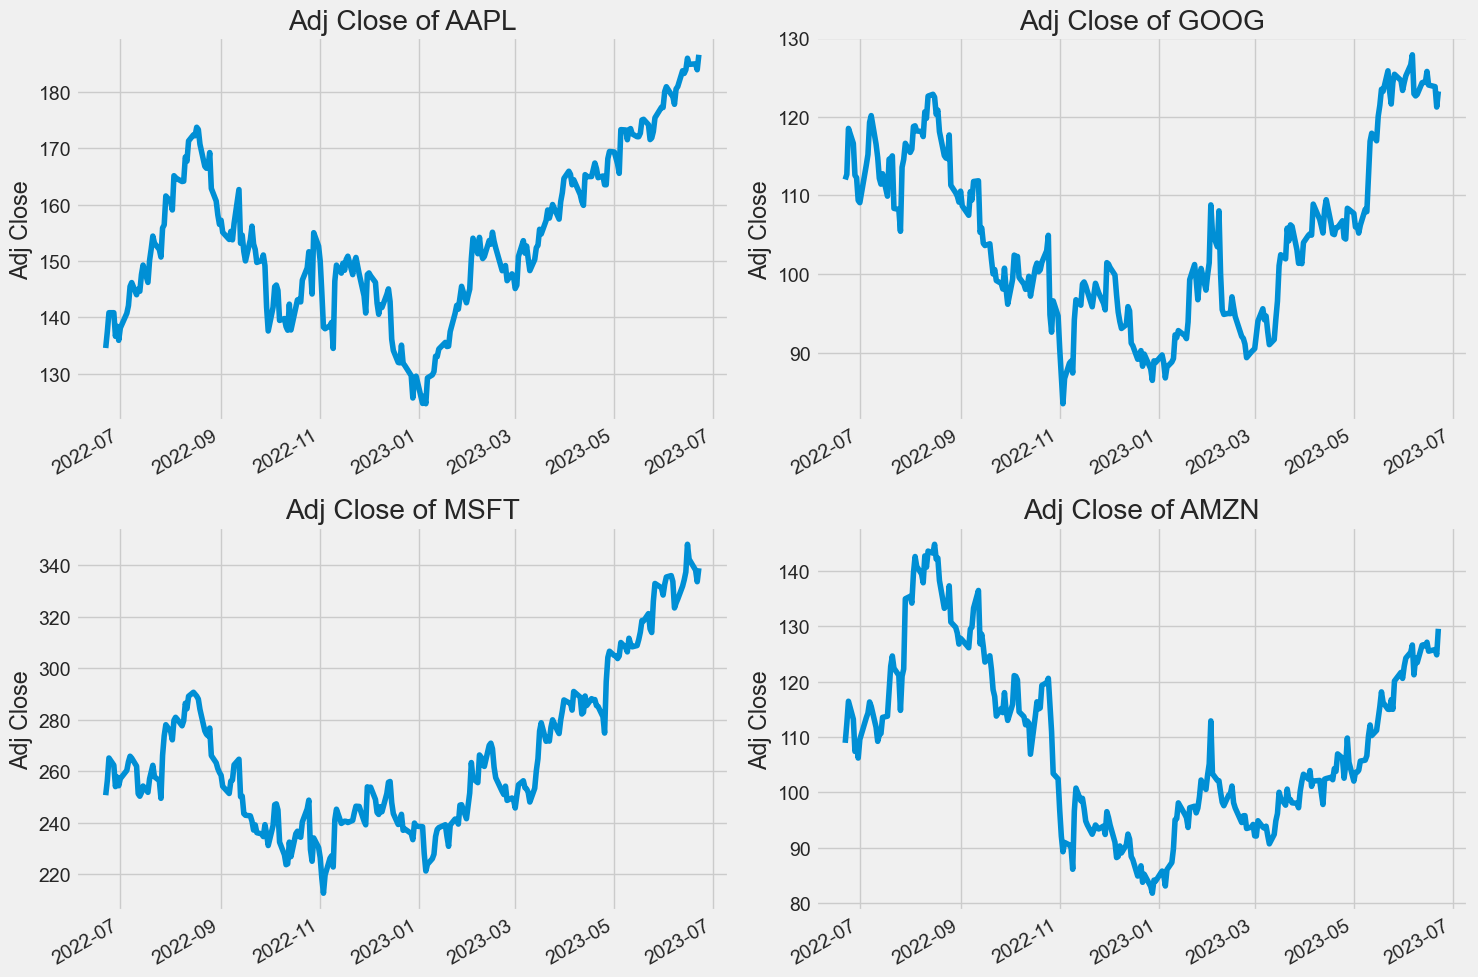

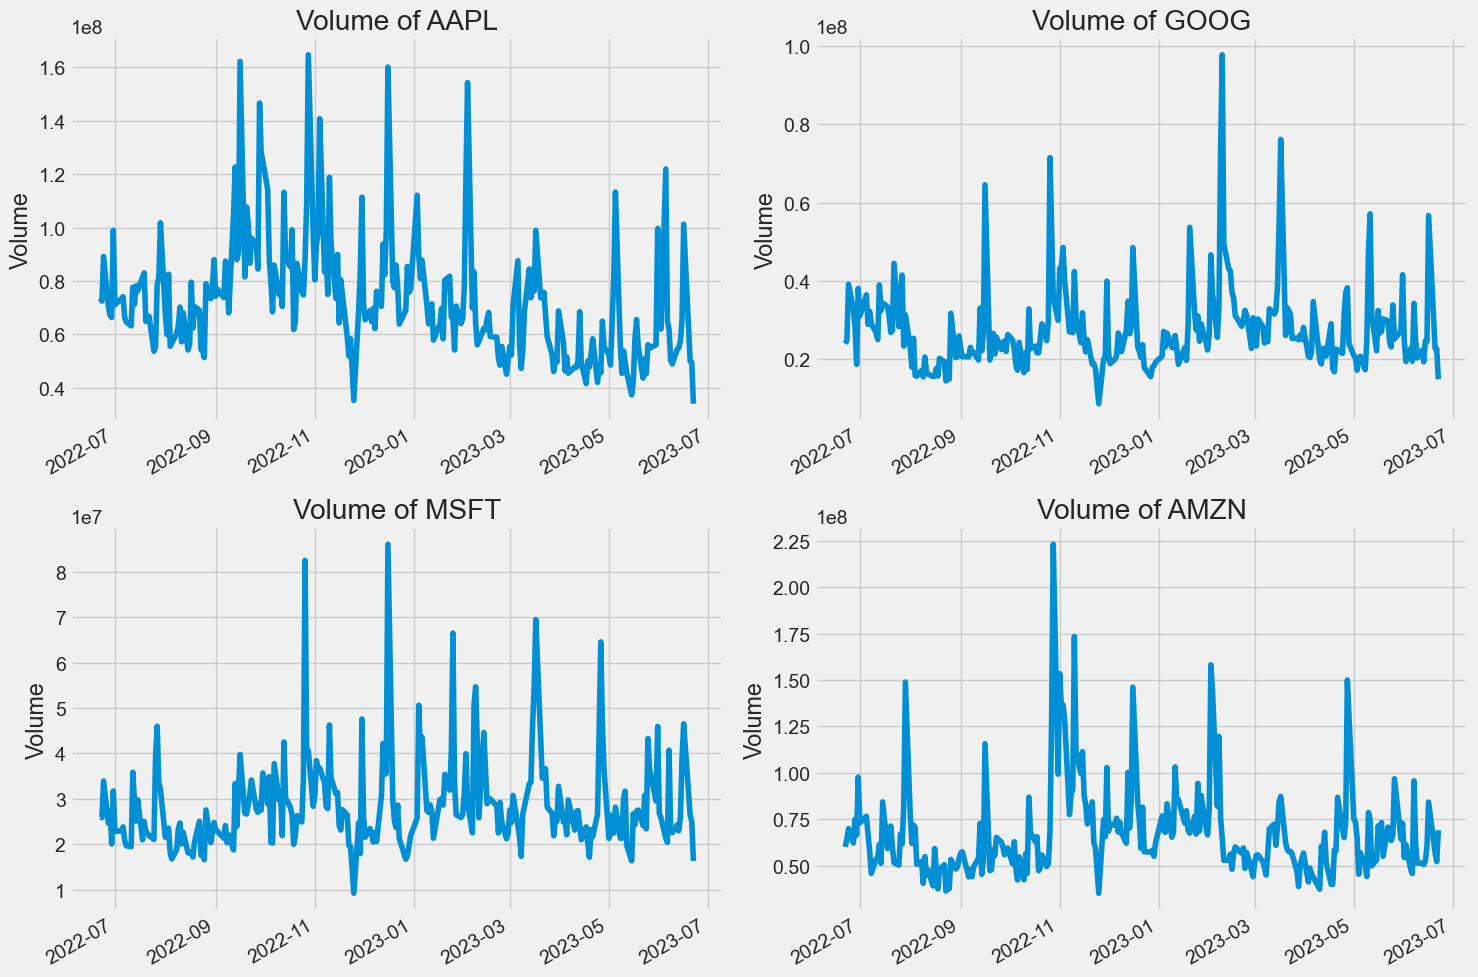

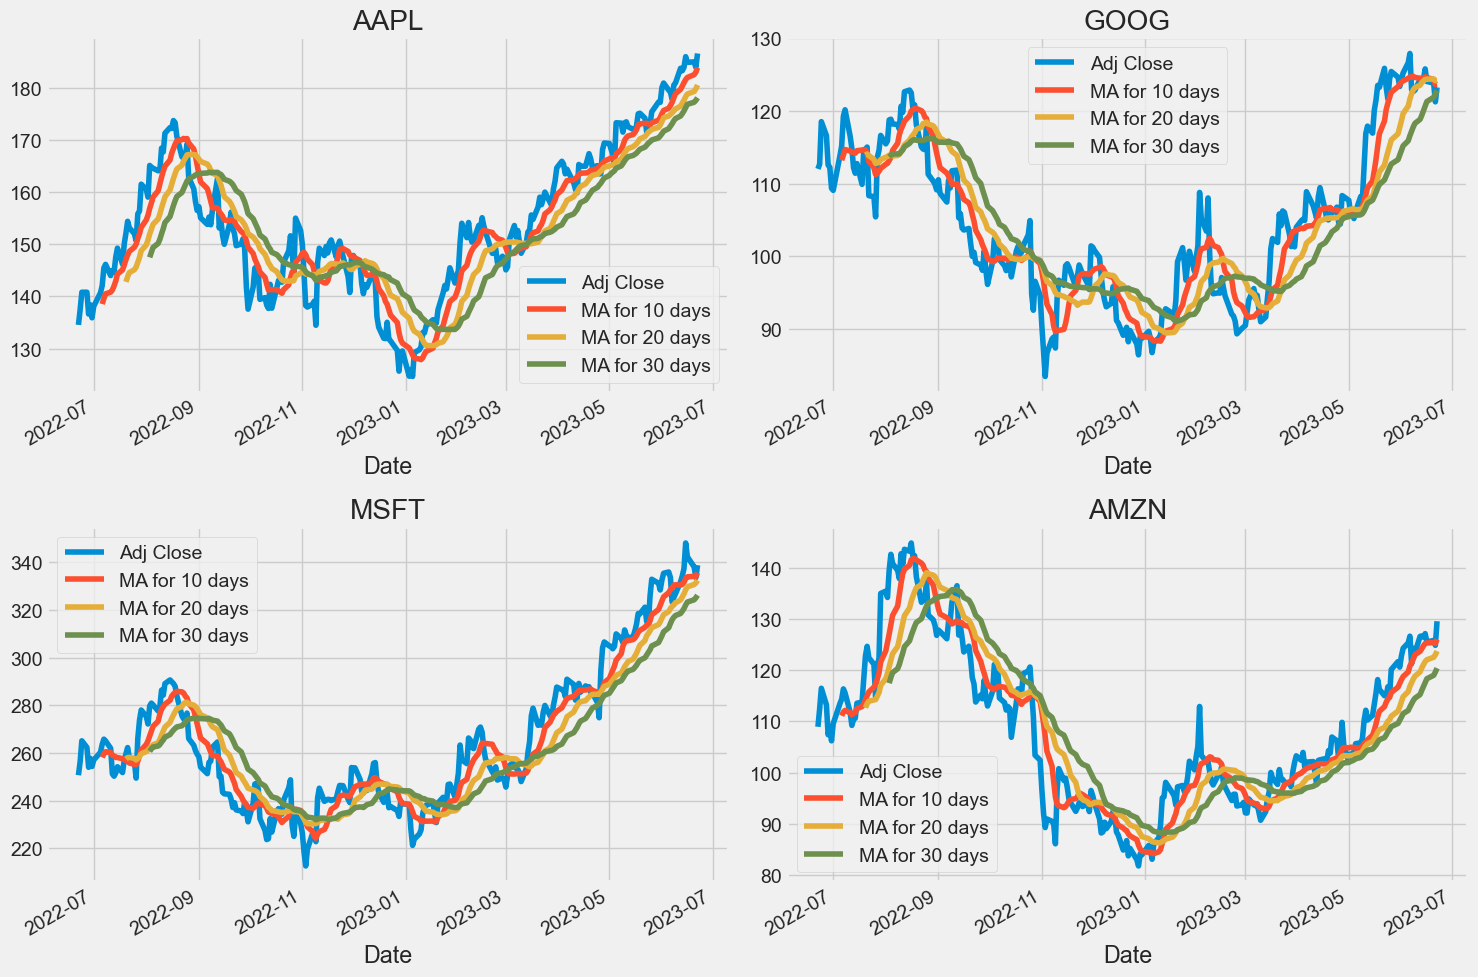

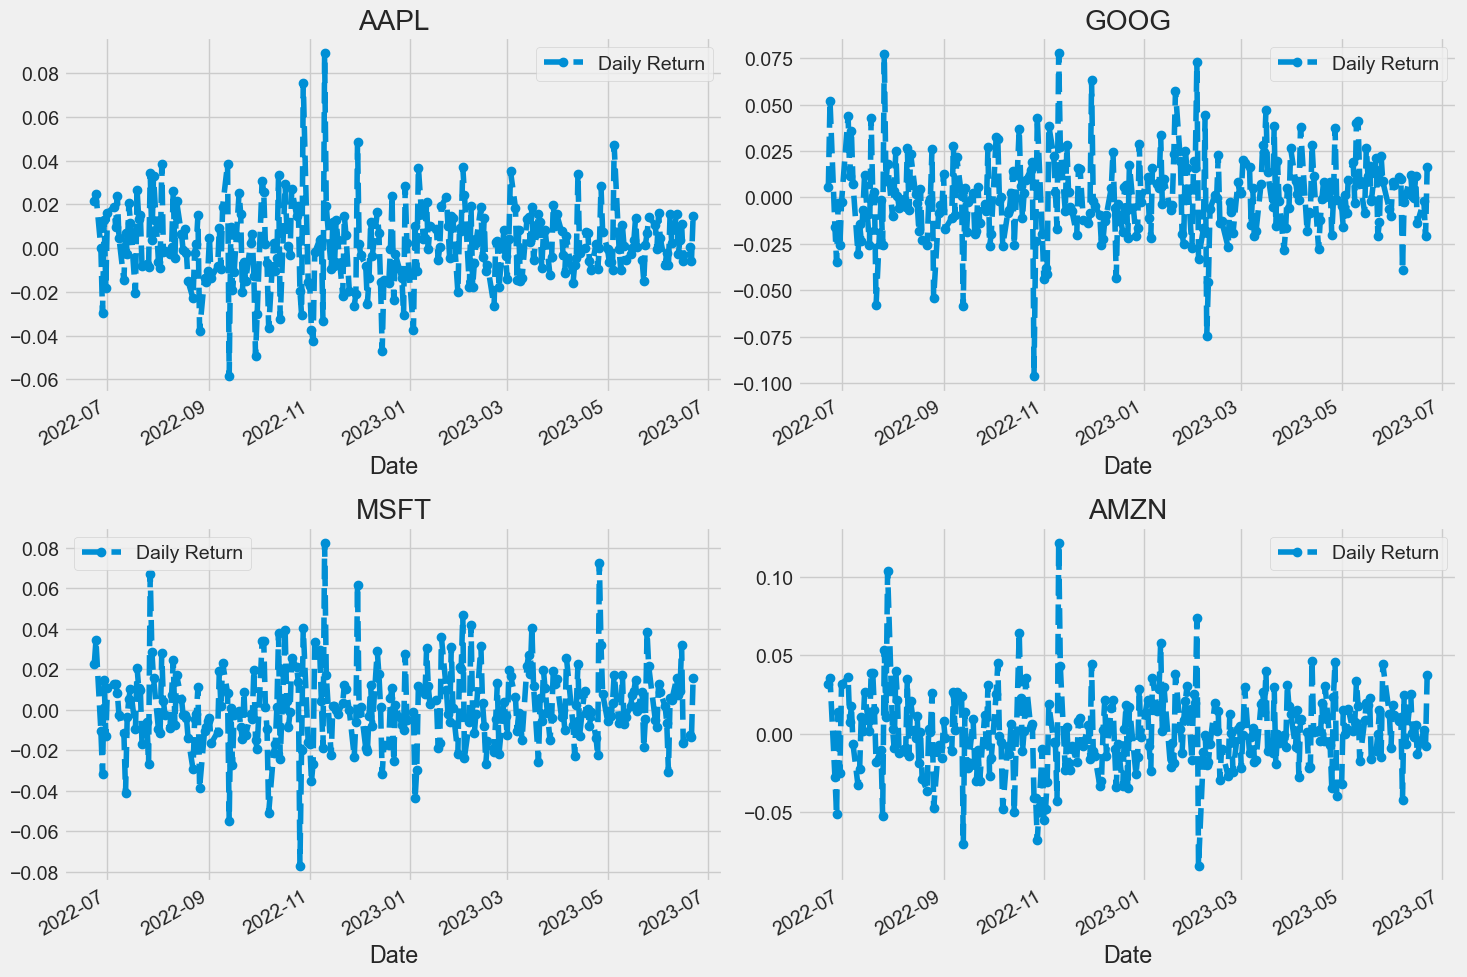

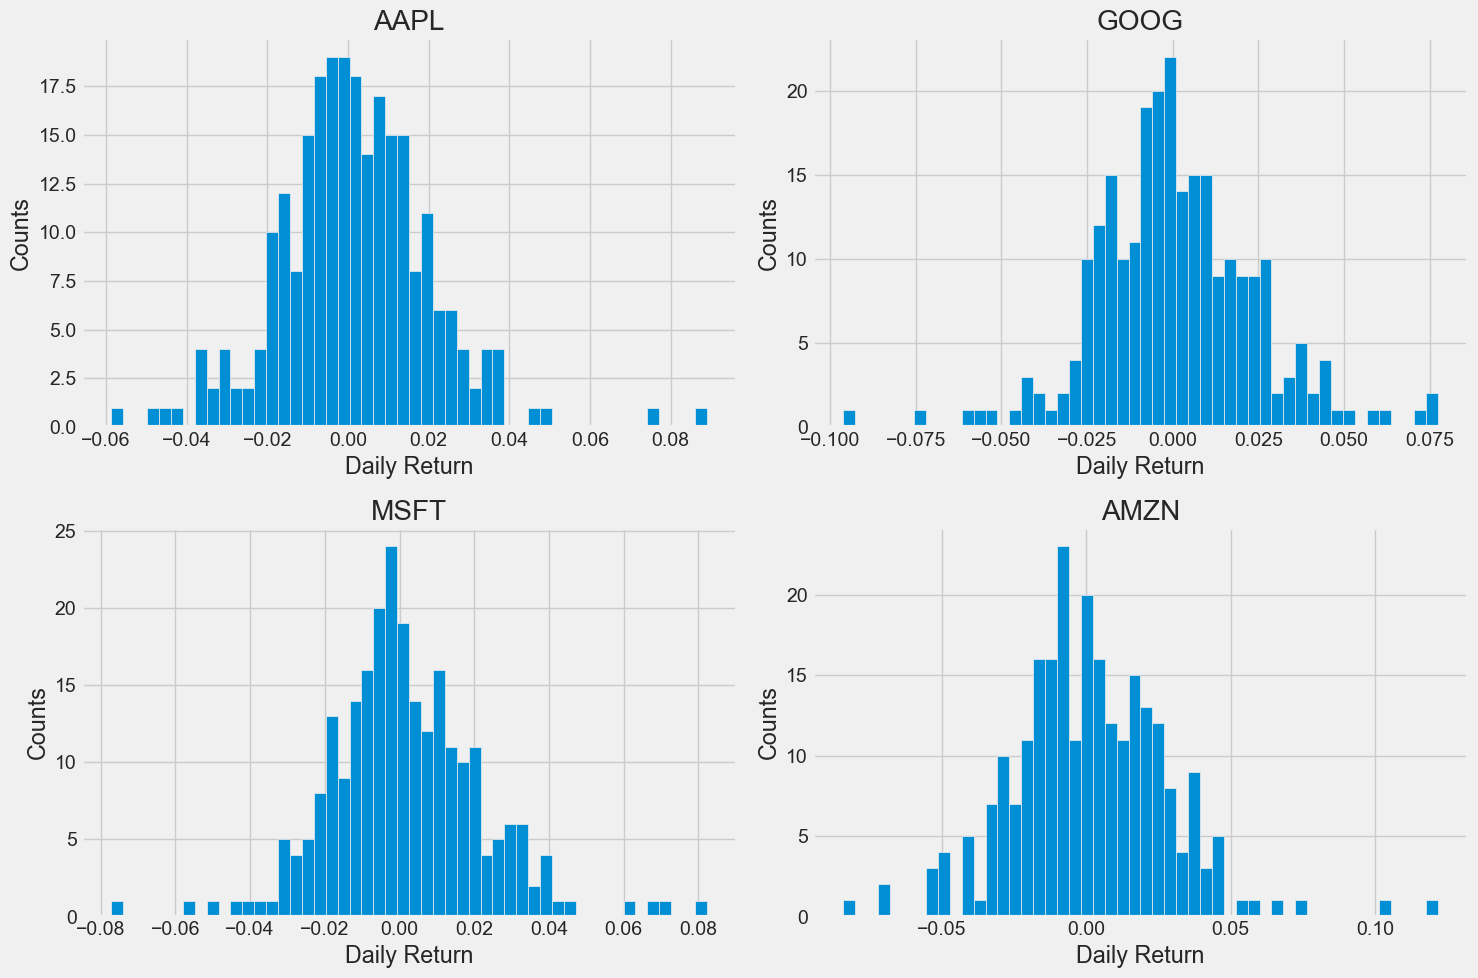

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


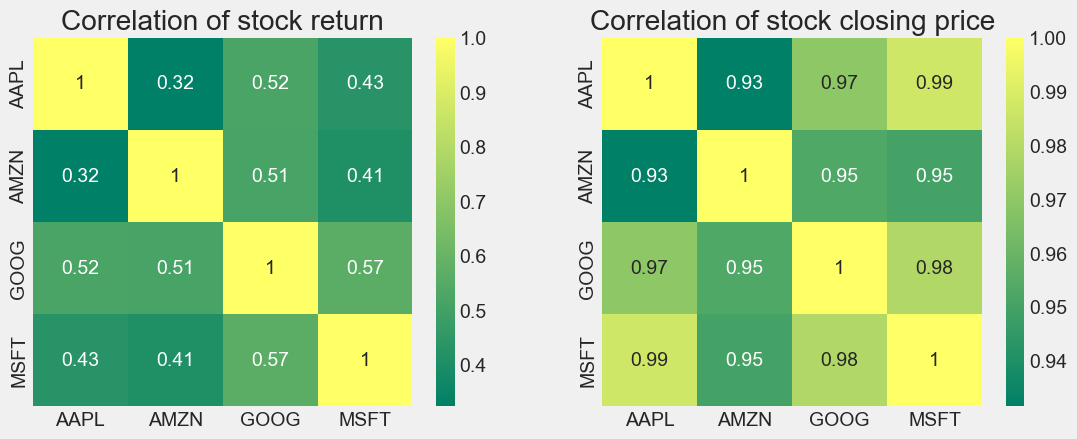

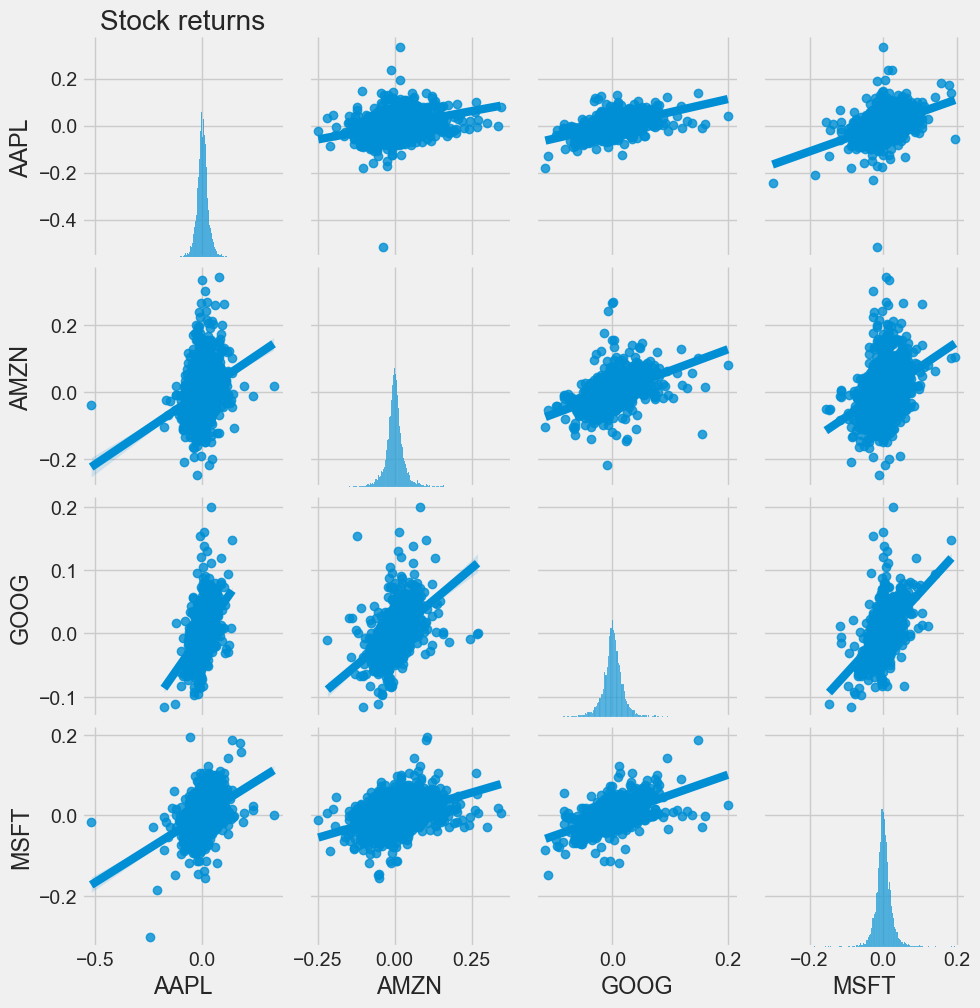

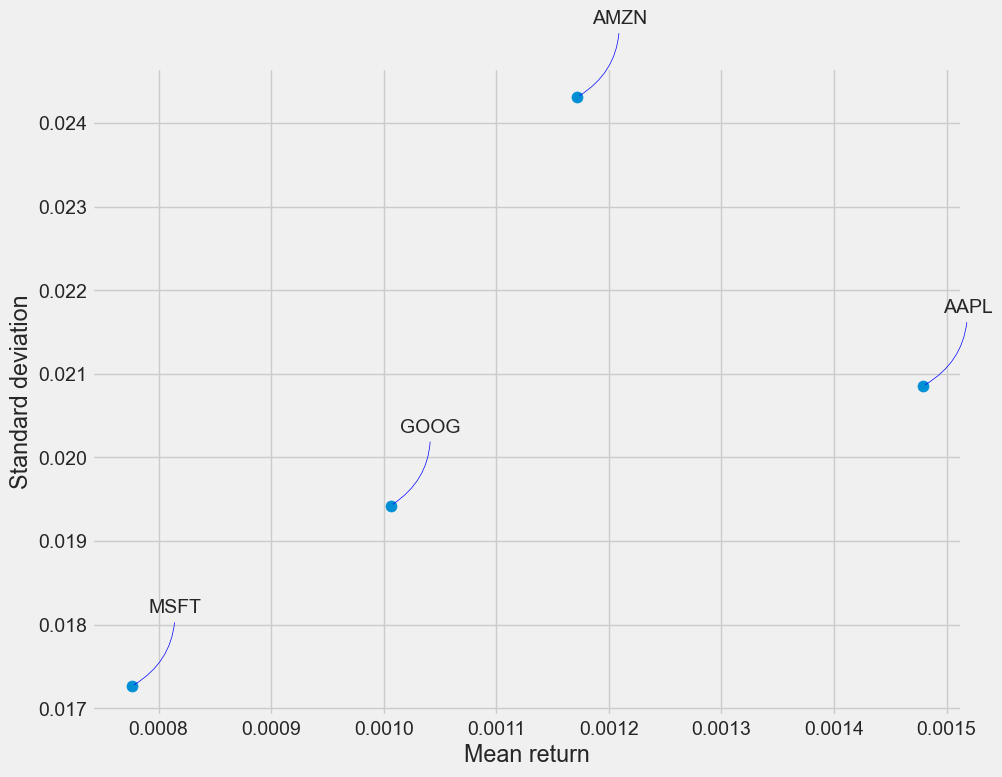

In [3]:
analyzer = StocksAnalyzer()
analyzer.analyze(["AAPL", "GOOG", "MSFT","AMZN"])

In [66]:
class StockAnalyzer():
    def __init__(self,ticker):
        self.security=yf.Ticker(ticker)
        self.market_data=yf.download(ticker)
        self.name=ticker
    
    
    def market_history(self,start=None,end=None,period=None):
        """
        This method downloads the market history of the stock over a specified period and plots it. Return the datframe of the 
        market prices. Default behavious is to plot all the available data
        
        start/end: string in the format YYYY/MM/DD to specify our interval
        period : string specifying how much we go back from today (1mo, 2mo, 3Y...)
        
        
        Doesn't raise errors when bad parameters given, but results are stupid....
        """
        
        
        if period!=None:
            histor=self.security.history(period=period)
        elif start!=None and end!=None:
            start = datetime.strptime(start, "%Y/%m/%d")
            end=datetime.strptime(end,"%Y/%m/%d")
            histor=self.security.history(start=start,end=end)
        else:
            print("No period specified, taking max available data.")
            histor=self.security.history(period="max")
        
        
        plt.figure(figsize=(15,10))
        plt.title(f"Market history of{self.name}")
        plt.plot(histor)
        
        return histor
    
    def dividend_history(self,start=None,end=None):
        """
        This method downloads the history of the dividends paid over a specified period and plots it. Return the datframe of the 
        dividends. Default behavious is to plot all the available data
        
        start/end: string in the format YYYY/MM/DD to specify our interval
        
        
        Doesn't raise errors when bad parameters given, but results are stupid....
        """
        histor=self.security.dividends
        if start!=None and end!=None:
            start = pd.to_datetime(start, format="%Y/%m/%d").tz_localize('America/New_York')
            end = pd.to_datetime(end, format="%Y/%m/%d").tz_localize('America/New_York')
            histor=histor[start:end]
            plt.title(f"Dividend history of {self.name}")
            histor.plot()
            
        else:
            print("No period specified, taking max available data.")
            plt.figure(figsize=(15,10))
            plt.title(f"Dividend history of {self.name}")
            plt.plot(histor)
        
        return histor

    def volume_history(self,start=None,end=None):
        """
        This method plots the volumes traded for this stock. Retruns the volume data.
        
        start/end: string in the format YYYY/MM/DD to specify our interval
        
        
        Doesn't raise errors when bad parameters given, but results are stupid....
        """        
        volumes=self.market_data["Volume"]
        if start!=None and end!=None:
            start = pd.to_datetime(start, format="%Y/%m/%d")
            end = pd.to_datetime(end, format="%Y/%m/%d")
            subvolumes = volumes[(volumes.index >= start) & (volumes.index <= end)]
            
            subvolumes.plot(title=f"Volume history of {self.name}")
        else:
            
            volumes.plot()
        return volumes
        
    def moving_average(self, ma_day=[10,20,30],start=None,end=None):
        """
        This method plots moving averages specified in ma_day. The self.market_data is modified inplace
        
        start/end: string in the format YYYY/MM/DD to specify our interval
        ma_day : list of integers representing the numeber of days for the moving averages to plot. Default is 10, 20, 30 days
        
        Doesn't raise errors when bad parameters given, but results are stupid....
        """        
        
        for ma in ma_day:
            
            column_name = f"MA for {ma} days"
            self.market_data[column_name] = self.market_data['Adj Close'].rolling(ma).mean()

        to_plot = ['Adj Close'] + [f'MA for {ma} days' for ma in ma_day]
        if start!=None and end!=None:
            start = pd.to_datetime(start, format="%Y/%m/%d")
            end = pd.to_datetime(end, format="%Y/%m/%d")
            sub = self.market_data[(self.market_data.index >= start) & (self.market_data.index <= end)]
            
            sub[to_plot].plot()
        else:
            self.market_data[to_plot].plot()
        
        plt.title(f"Moving averages of {self.name}")
        plt.tight_layout()
        plt.show()
        
        
    def daily_return(self, histo=False, start=None,end=None):
        """
        This method plots the daily return of the stock for a given period. It adds a column inplace for daily returns.
        
        histo : Boolean to choose if the plot is an histogram or a line chart. default is line chart.
        start/end: string in the format YYYY/MM/DD to specify our interval
        
        """
        

        self.market_data['Daily Return'] = self.market_data['Adj Close'].pct_change()
    
        
        fig=plt.figure()
        
        if start!=None and end!=None:
            start = pd.to_datetime(start, format="%Y/%m/%d")
            end = pd.to_datetime(end, format="%Y/%m/%d")

            if not histo:
                self.market_data[(self.market_data.index >= start) & (self.market_data.index <= end)]['Daily Return'].plot( legend=True, linestyle='--', marker='o')
            else: 
            
                self.market_data[(self.market_data.index >= start) & (self.market_data.index <= end)]['Daily Return'].hist(bins=50)
                plt.xlabel('Daily Return')
                plt.ylabel('Counts')
        else : 
            if not histo:
                self.market_data['Daily Return'].plot( legend=True, linestyle='--', marker='o')
            else: 
            
                self.market_data['Daily Return'].hist(bins=50)
                plt.xlabel('Daily Return')
                plt.ylabel('Counts')
        
        
        plt.title(f"Daily returns of {self.name}")
        plt.show()
        
        
    def volatility(self, start=None, end=None):
        """
        This method is used to plot the volatility and rate of volatility of the stock based on the available data up to that point.
        Modify the market_data inplace.

        start/end: string in the format YYYY/MM/DD to specify our interval. The std is computed using data prior to start.
        """
        self.market_data["Volatility"] = self.market_data["Adj Close"].expanding().std()
        self.market_data["Mean"] = self.market_data["Adj Close"].expanding().mean()
        self.market_data["Volatility Rate"] = self.market_data["Volatility"] / self.market_data["Mean"]

        if start != None and end != None:
            start = pd.to_datetime(start, format="%Y/%m/%d")
            end = pd.to_datetime(end, format="%Y/%m/%d")
            data = self.market_data[(self.market_data.index >= start) & (self.market_data.index <= end)]
        else:
            data = self.market_data

        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(data.index, data["Volatility"], linestyle='--', marker='o')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.title(f'Volatility of {self.name} based on past data')

        plt.subplot(2, 1, 2)
        plt.plot(data.index, data["Volatility Rate"], linestyle='--', marker='o')
        plt.xlabel('Date')
        plt.ylabel('Volatility Rate')
        plt.title(f'Rate of Volatility of {self.name} based on past data')

        plt.tight_layout()
        plt.show()


        
        
        

In [67]:
anal=StockAnalyzer('AAPL')

[*********************100%***********************]  1 of 1 completed


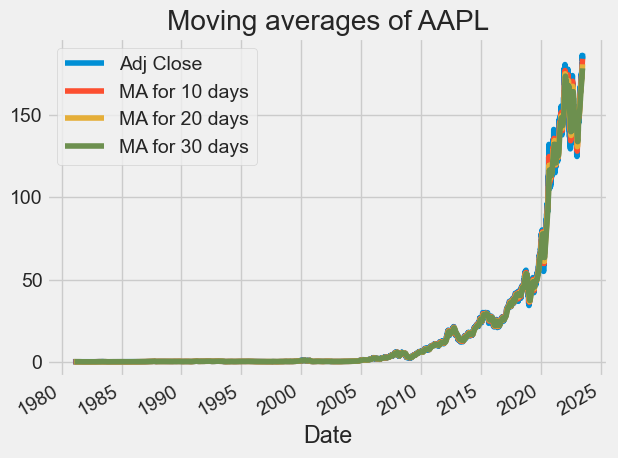

In [34]:
anal.moving_average()

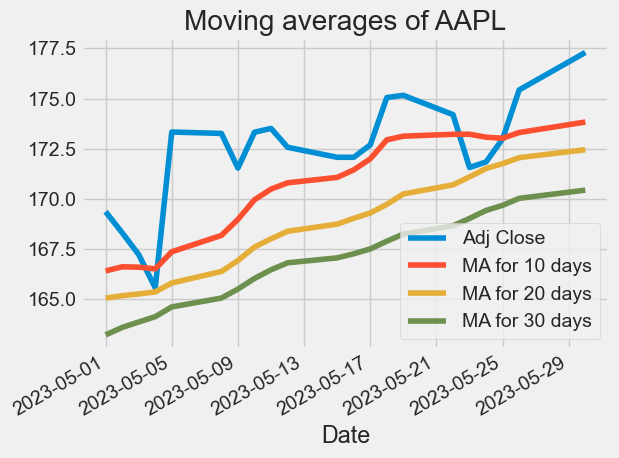

In [35]:
anal.moving_average(start='2023/05/01',end='2023/05/30')

Date
1980-12-12    469033600
1980-12-15    175884800
1980-12-16    105728000
1980-12-17     86441600
1980-12-18     73449600
                ...    
2023-06-15     65433200
2023-06-16    101235600
2023-06-20     49799100
2023-06-21     49515700
2023-06-22     50747851
Name: Volume, Length: 10721, dtype: int64

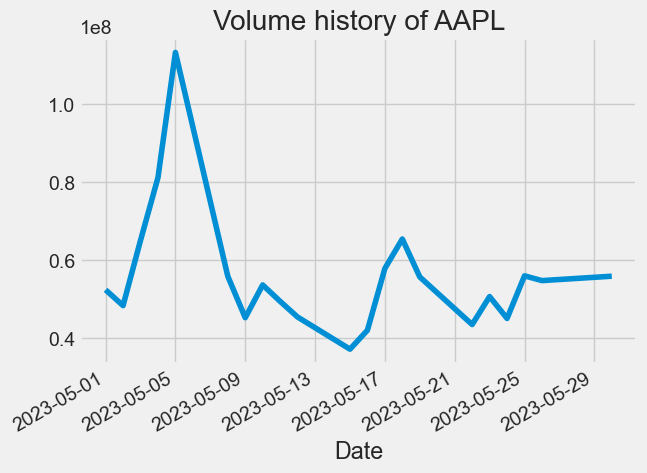

In [36]:
anal.volume_history(start='2023/05/01',end='2023/05/30')

Date
2023-05-12 00:00:00-04:00    0.24
Name: Dividends, dtype: float64

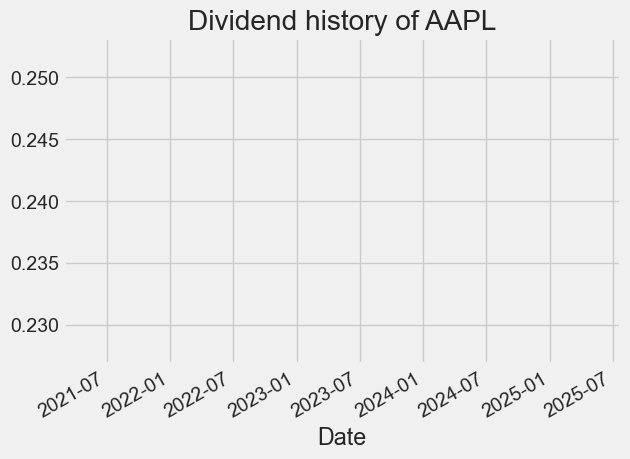

In [37]:
anal.dividend_history(start='2023/05/01',end='2023/05/30')

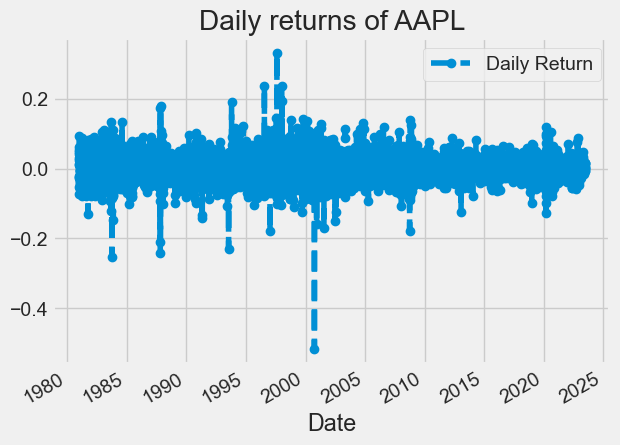

In [48]:
anal.daily_return()

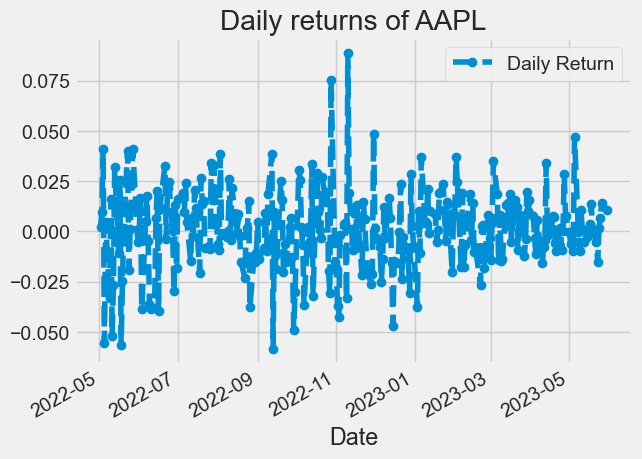

In [70]:
anal.daily_return(start='2022/05/01',end='2023/05/30')

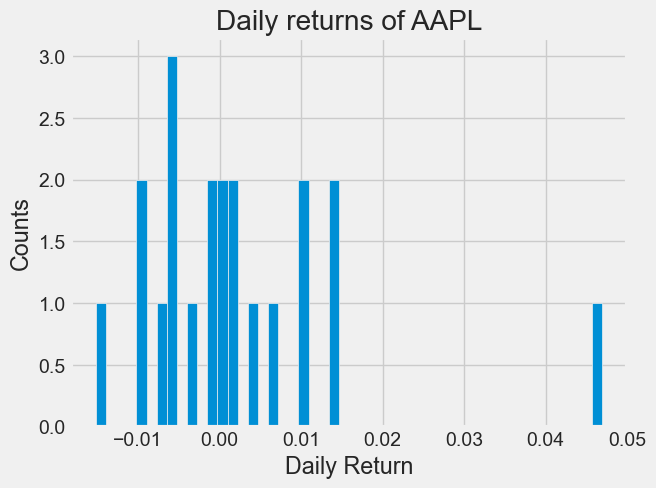

In [51]:
anal.daily_return(start='2023/05/01',end='2023/05/30',histo=True)

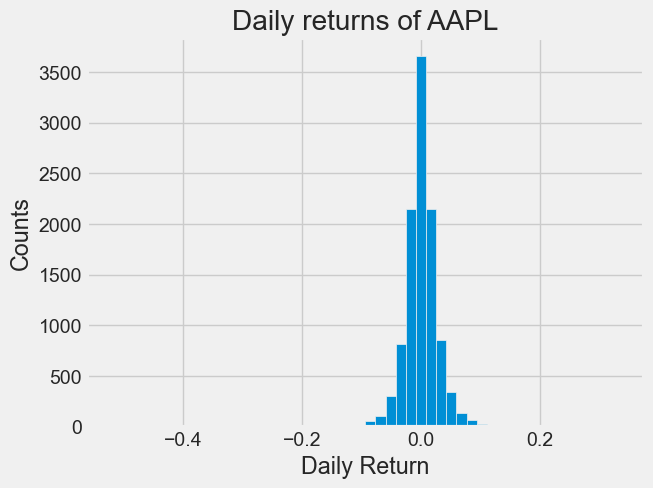

In [52]:
anal.daily_return(histo=True)

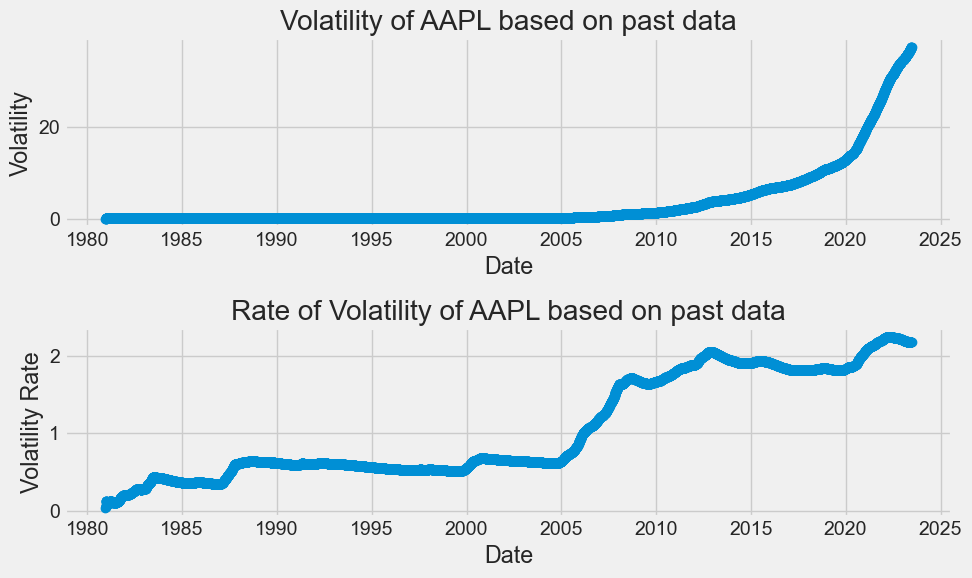

In [68]:
anal.volatility()

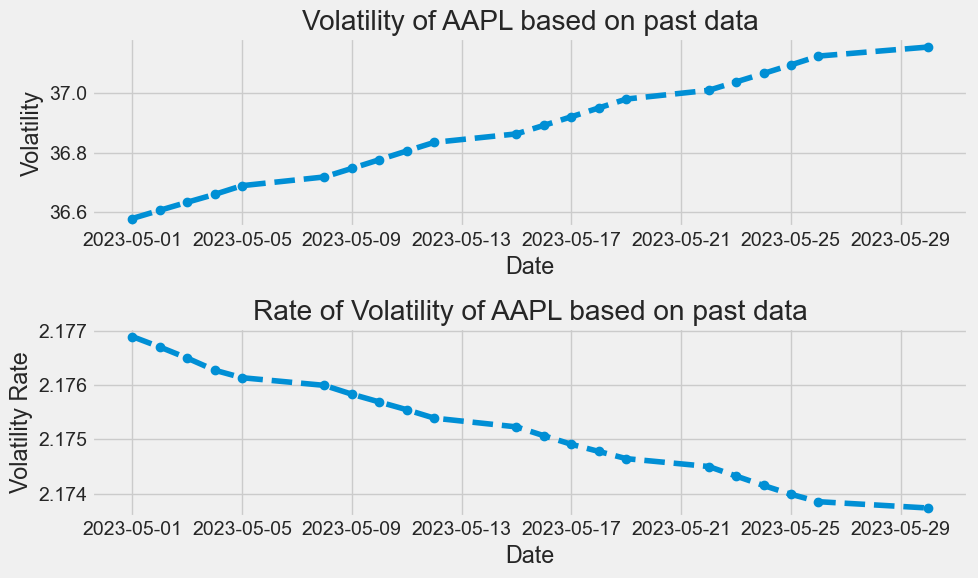

In [69]:
anal.volatility(start='2023/05/01',end='2023/05/30')